In [1]:
import pandas as pd 
import numpy as np 
import pyarrow as pa 
import pyarrow.parquet as pq
import warnings
from numba import jit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

# 数据导入与预处理

此部分将 wind 全 A 指数作为市场组合的收益率，与股票量价数据进行协偏度的计算，得到因子数据，之后将因子数据与估值行情数据合并得到最终需要读取的数据集

#### 设置数据导入路径，需要导入的数据有量价数据，wind 全 A 市场指数，日估值行情数据（市值等）

In [204]:
#设置导入路径，我们使用 f 字符串的方式导入，先设置的父目录
path ='/Users/hmt/Documents/PHBS/courses/investment/project/data'

In [205]:
# 使用fastparquet读取Parquet文件
price = pd.read_parquet(f'{path}/windA股日行情.parquet', engine='pyarrow')
ST = pd.read_parquet(f'{path}/windA股ST数据.parquet', engine='pyarrow')
classname = pd.read_parquet(f'{path}/申万行业分类.parquet', engine='pyarrow')
#导入做为对比的 WIND 全 A 市场指数净值时序图
windAshare = pd.read_parquet(f'{path}/wind全A指数日行情.parquet', engine='pyarrow')
windAshare['TRADE_DT'] = pd.to_datetime(windAshare['TRADE_DT'],format='%Y%m%d')
#导入估值日行情数据
mkt = pd.read_parquet(f'{path}/A股估值指标日行情.parquet',engine='pyarrow')
mkt['tradedate'] = pd.to_datetime(mkt['tradedate'],format='%Y%m%d')

KeyboardInterrupt: 

In [ ]:
# 调整日期格式，把日期列的数据类型从字符串转换为日期格式
price['tradedate'] = pd.to_datetime(price['tradedate'],format='%Y%m%d')
ST['ENTRY_DT'] = pd.to_datetime(ST['ENTRY_DT'],format='%Y%m%d')
ST['REMOVE_DT'] = pd.to_datetime(ST['REMOVE_DT'],format='%Y%m%d')
classname['ENTRY_DT'] = pd.to_datetime(classname['ENTRY_DT'],format='%Y%m%d')
classname['REMOVE_DT'] = pd.to_datetime(classname['REMOVE_DT'],format='%Y%m%d')
#把至今未移出的股票填充到今天不可能到达的日期，方便之后套用函数
ST['REMOVE_DT'].fillna(pd.to_datetime('20250101',format='%Y%m%d'), inplace=True)
classname['REMOVE_DT'].fillna(pd.to_datetime('20250101',format='%Y%m%d'), inplace=True)

注意：此处剔除了北交所的股票，只保留沪深两市的股票

In [ ]:
#剔除北交所股票
price =  price[~price['WINDCODE'].str.endswith('.BJ')]
#把量价数据进行排序
price.sort_values(by=['WINDCODE','tradedate'],inplace=True)
price.reset_index(inplace=True,drop=True)
#转化一下 pct_chg 的单位
price['pct_chg'] = price['复权close']/price['复权preclose']-1   


需要注意的是，实际中打上 ST，行业标签在分析部分完成，此处并没有完成该操作

In [ ]:
#更新标签函数，这个函数的调用可以给对应时间框内的股票打上标签，此部分操作即给股票打上 ST 和行业标签
def update_info_label(df_daily, df_info,label_columns,ENTRY_DT='ENTRY_DT',REMOVE_DT='REMOVE_DT',date='tradedate',WINDCODE='WINDCODE'):
    merge_data_test = pd.merge(df_daily,df_info,on=WINDCODE,how='left')
    condition = (merge_data_test[date]>=merge_data_test[ENTRY_DT])&(merge_data_test[date]<=merge_data_test[REMOVE_DT])
    merge_data_test = merge_data_test[condition]
    merge_data_test = merge_data_test[[WINDCODE,date]+label_columns]
    merge_data_test = merge_data_test.drop_duplicates([WINDCODE,date],keep='first')
    df_daily = pd.merge(df_daily,merge_data_test,on=[WINDCODE,date],how='left')
    df_daily.sort_values(by=[WINDCODE,date])
    return df_daily

#merge一下ST信息
price_ST = update_info_label(price,ST,label_columns=['ST_Type'],date='tradedate')

#merge一下行业lable
price_classname = update_info_label(price,classname,label_columns=['classcode'],date='tradedate')

In [ ]:
#合并量价数据与指数数据
all_stk = pd.merge(price,windAshare[['TRADE_DT','S_DQ_PCTCHANGE']],left_on='tradedate',right_on='TRADE_DT',how='left' )
all_stk ['S_DQ_PCTCHANGE'] = all_stk['S_DQ_PCTCHANGE']/100

In [ ]:
#合并完成后删除不必要的列
all_stk.drop(columns=['TRADE_DT'],inplace=True)

计算时，剔除了非交易日数据

In [ ]:
#清洗非交易日的数据
condition  = ((all_stk['交易状态']=='交易') | (all_stk['交易状态']=='XR') | 
             (all_stk['交易状态']=='XD') | (all_stk['交易状态']=='DR') |
            (all_stk['交易状态']=='N'))
all_stk = all_stk[condition]

In [ ]:
#由于计算只需要使用以下几列，因此用一个更小的 df 去进行计算，之后再 merge 回来
all_stk2=all_stk[['WINDCODE','tradedate','pct_chg','S_DQ_PCTCHANGE']]

In [ ]:
all_stk2.reset_index(inplace=True,drop=True)

In [ ]:
all_stk2

,WINDCODE,tradedate,pct_chg,S_DQ_PCTCHANGE
0,000001.SZ,1997-12-31,-0.007876,0.011970
1,000001.SZ,1998-01-05,0.057280,0.024777
2,000001.SZ,1998-01-06,-0.006658,0.011491
3,000001.SZ,1998-01-07,-0.018876,0.011489
4,000001.SZ,1998-01-08,-0.010704,-0.002239
...,...,...,...,...
14626667,T00018.SH,2006-09-19,-0.002347,0.002320
14626668,T00018.SH,2006-09-20,-0.004277,0.001748
14626669,T00018.SH,2006-09-21,0.001074,0.005578
14626670,T00018.SH,2006-09-22,0.006222,-0.008992


# 1.股票收益协偏度因子

计算公式：
$$\text{CSK}_{XYY} = \frac{\operatorname{E}\left((X - \mathbb{E}[X])(Y - \mathbb{E}[Y])^2\right)}{\sigma_X \sigma_Y^2}$$

In [ ]:
@jit(nopython=True)
def calculate_rolling_csk_numba(x_values, y_values, X):
    # 初始化CSK列
    csk_values = np.empty(len(x_values))
    csk_values[:X] = np.nan
    
    # 使用Numba的nopython模式来加速计算
    for i in range(X, len(x_values)):
        x_subset = x_values[i-X:i]
        y_subset = y_values[i-X:i]
        
        x_mean = np.mean(x_subset)
        y_mean = np.mean(y_subset)
        
        numerator = np.mean((x_subset - x_mean) * ((y_subset - y_mean)**2))
        denominator = np.std(x_subset) * (np.std(y_subset)**2)
        csk = numerator / denominator if denominator != 0 else np.nan
        csk_values[i] = csk
    
    return csk_values

def calculate_rolling_csk(group, X=20, column_name='CSK'):
    # 提取所有需要的数据
    x_values = group['pct_chg'].values
    y_values = group['S_DQ_PCTCHANGE'].values
    
    # 使用Numba加速的函数来计算CSK
    csk_values = calculate_rolling_csk_numba(x_values, y_values, X)
    
    # 将结果存储在列中
    group[column_name] = np.nan
    group.loc[group.index[X:], column_name] = csk_values[X:]

    return group

In [ ]:
#使用前一定要确保对输入的股票索引进行reset
for X in [20,60,120,240]:
    column_name = f'CSK_XYY_{X}D'
    all_stk2[column_name] = all_stk2.groupby('WINDCODE').apply(lambda g: calculate_rolling_csk(g, X,column_name)).reset_index(drop=True)[column_name]

In [ ]:
all_stk2.isna().mean()

WINDCODE          0.000000
tradedate         0.000000
pct_chg           0.000000
S_DQ_PCTCHANGE    0.000000
CSK_XYY_20D       0.007326
CSK_XYY_60D       0.021965
CSK_XYY_120D      0.043853
CSK_XYY_240D      0.087161
dtype: float64

In [ ]:
all_stk2.head()

,WINDCODE,tradedate,pct_chg,S_DQ_PCTCHANGE,CSK_XYY_20D,CSK_XYY_60D,CSK_XYY_120D,CSK_XYY_240D
0,000001.SZ,1997-12-31,-0.007876,0.011970,NaN,NaN,NaN,NaN
1,000001.SZ,1998-01-05,0.057280,0.024777,NaN,NaN,NaN,NaN
2,000001.SZ,1998-01-06,-0.006658,0.011491,NaN,NaN,NaN,NaN
3,000001.SZ,1998-01-07,-0.018876,0.011489,NaN,NaN,NaN,NaN
4,000001.SZ,1998-01-08,-0.010704,-0.002239,NaN,NaN,NaN,NaN


# 2.股票收益上行协偏度因子

计算公式1(上行协偏度因子)：
$$\text{CSK\_UP}_{XYY} = \frac{\operatorname{E}\left[(X - \mathbb{E}[X])(Y - \mathbb{E}[Y])^2|Y>\mathbb{E}[Y]\right]}{sqrt(E\left[(X - \mathbb{E}[X])^2|Y>\mathbb{E}[Y]])*E[(Y - \mathbb{E}[Y])^2|Y>\mathbb{E}[Y]\right]}$$

In [ ]:
@jit(nopython=True)
def calculate_rolling_csk_up_numba(x_values, y_values, X):
    # 初始化CSK列
    csk_up_values = np.empty(len(x_values))
    csk_up_values[:X] = np.nan
    # 使用Numba的nopython模式来加速计算
    for i in range(X, len(x_values)):
        x_subset = x_values[i-X:i]
        y_subset = y_values[i-X:i]

        x_mean = x_subset.mean()
        y_mean = y_subset.mean()

        var_X_given = np.mean(((x_subset - x_mean)**2)[y_subset>y_mean])
        var_Y_given = np.mean(((y_subset - y_mean)**2)[y_subset>y_mean])

        numerator = np.mean(((x_subset - x_mean) * ((y_subset - y_mean)**2))[y_subset>y_mean])
        denominator = np.sqrt(var_X_given) * var_Y_given
        
        csk_up_xyy = numerator / denominator if denominator != 0 else np.nan
        csk_up_values[i] = csk_up_xyy
    
    return csk_up_values

def calculate_rolling_csk_up(group, X, column_name='CSK_UP'):
    # 提取所有需要的数据
    x_values = group['pct_chg'].values
    y_values = group['S_DQ_PCTCHANGE'].values
    # 使用Numba加速的函数来计算CSK
    csk_up_values = calculate_rolling_csk_up_numba(x_values, y_values, X)
    # 将结果存储在列中
    group[column_name] = np.nan
    group.loc[group.index[X:], column_name] = csk_up_values[X:]
    return group

In [ ]:
for X in [20,60,120,240]:
    column_name = f'CSK_XYY_UP_{X}D'
    all_stk2[column_name] = all_stk2.groupby('WINDCODE').apply(lambda g: calculate_rolling_csk_up(g, X ,column_name)).reset_index(drop=True)[column_name]

In [ ]:
all_stk2.isna().mean()

WINDCODE           0.000000
tradedate          0.000000
pct_chg            0.000000
S_DQ_PCTCHANGE     0.000000
CSK_XYY_20D        0.007326
CSK_XYY_60D        0.021965
CSK_XYY_120D       0.043853
CSK_XYY_240D       0.087161
CSK_XYY_UP_20D     0.007326
CSK_XYY_UP_60D     0.021965
CSK_XYY_UP_120D    0.043853
CSK_XYY_UP_240D    0.087161
dtype: float64

In [ ]:
all_stk2.head()

,WINDCODE,tradedate,pct_chg,S_DQ_PCTCHANGE,CSK_XYY_20D,CSK_XYY_60D,CSK_XYY_120D,CSK_XYY_240D,CSK_XYY_UP_20D,CSK_XYY_UP_60D,CSK_XYY_UP_120D,CSK_XYY_UP_240D
0,000001.SZ,1997-12-31,-0.007876,0.011970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001.SZ,1998-01-05,0.057280,0.024777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001.SZ,1998-01-06,-0.006658,0.011491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001.SZ,1998-01-07,-0.018876,0.011489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000001.SZ,1998-01-08,-0.010704,-0.002239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.股票收益下行协偏度因子 

计算公式2(下行协偏度因子）：
$$\text{CSK\_DOWN}_{XYY} = \frac{\operatorname{E}\left[(X - \mathbb{E}[X])(Y - \mathbb{E}[Y])^2|Y<\mathbb{E}[Y]\right]}{sqrt(E\left[(X - \mathbb{E}[X])^2|Y<\mathbb{E}[Y]])*E[(Y - \mathbb{E}[Y])^2|Y<\mathbb{E}[Y]\right]}$$

In [ ]:
@jit(nopython=True)
def calculate_rolling_csk_down_numba(x_values, y_values, X):
    # 初始化CSK列
    csk_down_values = np.empty(len(x_values))
    csk_down_values[:X] = np.nan
    # 使用Numba的nopython模式来加速计算
    for i in range(X, len(x_values)):
        x_subset = x_values[i-X:i]
        y_subset = y_values[i-X:i]

        x_mean = x_subset.mean()
        y_mean = y_subset.mean()

        var_X_given = np.mean(((x_subset - x_mean)**2)[y_subset<y_mean])
        var_Y_given = np.mean(((y_subset - y_mean)**2)[y_subset<y_mean])

        numerator = np.mean(((x_subset - x_mean) * ((y_subset - y_mean)**2))[y_subset<y_mean])
        denominator = np.sqrt(var_X_given) * var_Y_given
        
        csk_down_xyy = numerator / denominator if denominator != 0 else np.nan
        csk_down_values[i] = csk_down_xyy
    
    return csk_down_values

def calculate_rolling_csk_down(group, X, column_name='CSK_DOWN'):
    # 提取所有需要的数据
    x_values = group['pct_chg'].values
    y_values = group['S_DQ_PCTCHANGE'].values
    # 使用Numba加速的函数来计算CSK
    csk_down_values = calculate_rolling_csk_down_numba(x_values, y_values, X)
    # 将结果存储在列中
    group[column_name] = np.nan
    group.loc[group.index[X:], column_name] = csk_down_values[X:]
    return group

In [ ]:
for X in [20,60,120,240]:
    column_name = f'CSK_XYY_DOWN_{X}D'
    all_stk2[column_name] = all_stk2.groupby('WINDCODE').apply(lambda g: calculate_rolling_csk_down(g, X ,column_name)).reset_index(drop=True)[column_name]

In [ ]:
all_stk2.isna().mean()

WINDCODE             0.000000
tradedate            0.000000
pct_chg              0.000000
S_DQ_PCTCHANGE       0.000000
CSK_XYY_20D          0.007326
CSK_XYY_60D          0.021965
CSK_XYY_120D         0.043853
CSK_XYY_240D         0.087161
CSK_XYY_UP_20D       0.007326
CSK_XYY_UP_60D       0.021965
CSK_XYY_UP_120D      0.043853
CSK_XYY_UP_240D      0.087161
CSK_XYY_DOWN_20D     0.007326
CSK_XYY_DOWN_60D     0.021965
CSK_XYY_DOWN_120D    0.043853
CSK_XYY_DOWN_240D    0.087161
dtype: float64

In [ ]:
all_stk2.tail(20)

,WINDCODE,tradedate,pct_chg,S_DQ_PCTCHANGE,CSK_XYY_20D,CSK_XYY_60D,CSK_XYY_120D,CSK_XYY_240D,CSK_XYY_UP_20D,CSK_XYY_UP_60D,CSK_XYY_UP_120D,CSK_XYY_UP_240D,CSK_XYY_DOWN_20D,CSK_XYY_DOWN_60D,CSK_XYY_DOWN_120D,CSK_XYY_DOWN_240D
14626652,T00018.SH,2006-08-29,-0.001925,0.002304,-0.827938,0.502658,0.318539,0.319472,1.248082,0.693614,0.947665,0.960144,-1.733623,0.396353,-0.109404,-0.142332
14626653,T00018.SH,2006-08-30,-0.002357,0.005566,-0.425081,0.492578,0.324071,0.319319,1.357322,0.304599,0.943936,0.969783,-1.567763,0.459628,-0.106539,-0.147036
14626654,T00018.SH,2006-08-31,-0.002577,0.004984,-0.541581,0.769727,0.327552,0.317928,1.340905,0.459674,0.958248,0.976533,-1.723680,0.758717,-0.102609,-0.147886
14626655,T00018.SH,2006-09-01,-0.001723,-0.016688,-0.679448,-0.231400,0.327118,0.320029,1.403130,0.549004,0.958144,0.978697,-1.777401,-0.583154,-0.102787,-0.146741
14626656,T00018.SH,2006-09-04,0.000647,0.016852,-0.541172,-0.288611,0.340456,0.319828,1.374970,0.595883,0.966591,0.972366,-1.535288,-0.620669,-0.091789,-0.147838
14626657,T00018.SH,2006-09-05,0.005389,0.002401,-0.402797,-0.291793,0.337649,0.314016,1.194758,0.563615,0.956104,0.963476,-1.690615,-0.607542,-0.084734,-0.150160
14626658,T00018.SH,2006-09-06,0.004288,0.004593,-0.711818,-0.318179,0.339482,0.311147,0.967505,0.548654,0.950591,0.965509,-1.453399,-0.627675,-0.083856,-0.151316
14626659,T00018.SH,2006-09-07,-0.004270,-0.014060,-0.850464,-0.327011,0.334343,0.308321,0.666572,0.538366,0.971548,0.969006,-1.529958,-0.633181,-0.085266,-0.152521
14626660,T00018.SH,2006-09-08,-0.002358,0.002378,-0.720231,-0.317792,0.368128,0.313699,0.751167,0.549741,0.966990,0.969610,-1.321442,-0.628376,-0.035486,-0.150302
14626661,T00018.SH,2006-09-11,0.000000,0.005274,-0.679930,-0.342706,0.365381,0.319686,0.741525,0.551698,0.960327,0.984787,-1.367243,-0.642369,-0.037633,-0.147627


# 一些画图

In [299]:
#导入
all_stk2 = pd.read_parquet('huatu_csk.parquet',engine='pyarrow')

## PCA降维展示

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
test_pca = all_stk2[all_stk2.tradedate == pd.to_datetime('2021-08-31')]
test_pca.dropna(inplace=True)
test_pca.reset_index(inplace=True)

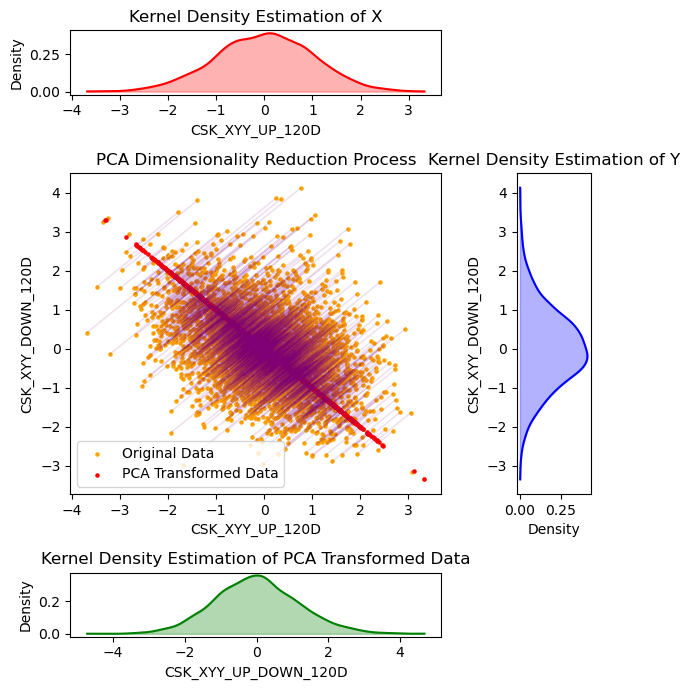

In [26]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec

# 示例数据
x = (test_pca['CSK_XYY_UP_120D'] - test_pca['CSK_XYY_UP_120D'].mean()) / test_pca['CSK_XYY_UP_120D'].std()
y = (test_pca['CSK_XYY_DOWN_120D'] - test_pca['CSK_XYY_DOWN_120D'].mean()) / test_pca['CSK_XYY_DOWN_120D'].std()
data = np.vstack((x, y)).T

# 执行PCA
pca = PCA(n_components=1)
data_pca = pca.fit_transform(data)
data_pca_inv = pca.inverse_transform(data_pca)

# 创建一个包含四个子图的图形
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 5, 1], height_ratios=[1, 5, 1])  # 调整宽度和高度比例

# 在主图中绘制原始数据和PCA结果的散点图
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(x, y, color='#FFA500', label='Original Data', s=5)  # 修改散点大小
ax1.scatter(data_pca_inv[:, 0], data_pca_inv[:, 1], color='red', label='PCA Transformed Data', s=5)  # 修改散点大小

# 绘制从原始数据到PCA结果的映射箭头
for i in range(len(x)):
    ax1.arrow(x[i], y[i], data_pca_inv[i, 0] - x[i], data_pca_inv[i, 1] - y[i], color='purple', alpha=0.1, head_width=0.001)

ax1.set_title('PCA Dimensionality Reduction Process')
ax1.set_xlabel('CSK_XYY_UP_120D')
ax1.set_ylabel('CSK_XYY_DOWN_120D')
ax1.legend()

# 在上方子图中绘制 X 的密度图
ax2 = plt.subplot(gs[0, 1])
density_x = gaussian_kde(x)
xs = np.linspace(x.min(), x.max(), 200)
ax2.plot(xs, density_x(xs), color='#FF0000')
ax2.fill_between(xs, density_x(xs), color='#FF0000', alpha=0.3)  # 填充颜色
ax2.set_title('Kernel Density Estimation of X')
ax2.set_xlabel('CSK_XYY_UP_120D')
ax2.set_ylabel('Density')

# 在右侧子图中绘制 Y 的密度图
ax3 = plt.subplot(gs[1, 2])
density_y = gaussian_kde(y)
ys = np.linspace(y.min(), y.max(), 200)
ax3.plot(density_y(ys), ys, color='#0000FF')
ax3.fill_betweenx(ys, density_y(ys), color='#0000FF', alpha=0.3)  # 填充颜色
ax3.set_title('Kernel Density Estimation of Y')
ax3.set_xlabel('Density')
ax3.set_ylabel('CSK_XYY_DOWN_120D')

# 在下方子图中绘制合成后的数组的核密度图
ax4 = plt.subplot(gs[2, 1])
density_pca = gaussian_kde(data_pca.flatten())
xs_pca = np.linspace(data_pca.min(), data_pca.max(), 200)
ax4.plot(xs_pca, density_pca(xs_pca), color='#008000')
ax4.fill_between(xs_pca, density_pca(xs_pca), color='#008000', alpha=0.3)  # 填充颜色
ax4.set_title('Kernel Density Estimation of PCA Transformed Data')
ax4.set_xlabel('CSK_XYY_UP_DOWN_120D')
ax4.set_ylabel('Density')

plt.tight_layout()
plt.show()

## 前景理论展示

### 权重函数

$$w(p) = \frac{p^{\gamma}}{(p^{\gamma} + (1 - p)^{\gamma})^{\frac{1}{\gamma}}} \ , \gamma=0.65 $$

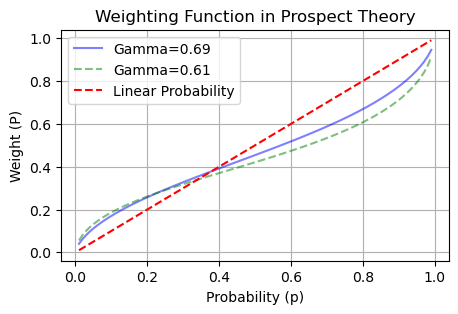

In [294]:
# 定义权重函数
def weighting_function(p, gamma):
    """
    p: 概率
    gamma: 权重函数的参数
    """
    return (p**gamma) / ((p**gamma + (1 - p)**gamma)**(1/gamma))

# 生成数据
p = np.linspace(0.01, 0.99, 100)
w_069 = [weighting_function(i, 0.69) for i in p]
w_061 = [weighting_function(i, 0.61) for i in p]

# 绘制图形
plt.figure(figsize=(5, 3))
plt.plot(p, w_069, label='Gamma=0.69', color='blue',alpha=0.5)
plt.plot(p, w_061, label='Gamma=0.61', color='green',linestyle = '--', alpha=0.5)
plt.plot(p, p, label='Linear Probability', linestyle='--', color='red')
plt.xlabel('Probability (p)')
plt.ylabel('Weight (P)')
plt.title('Weighting Function in Prospect Theory')
plt.legend()
plt.grid(True)
plt.show()

### 价值函数

$$
V(x) = 
\begin{cases} 
x^{\alpha} & \text{if } x \geq 0 \\
-\lambda (-x)^{\alpha} & \text{if } x < 0 
\end{cases}
\quad \text{其中 } \alpha = 0.88, \lambda = 2.25
$$

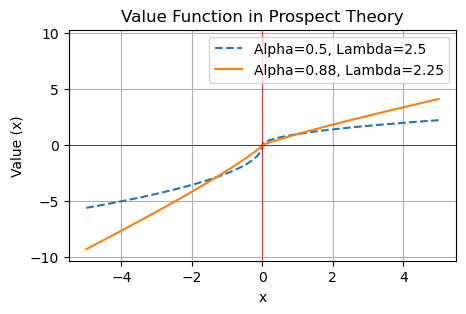

In [297]:
# 定义价值函数
def value_function(x, alpha=0.88, lambda_=2.25):
    """
    x: 输入值
    alpha: 风险厌恶系数
    lambda_: 损失厌恶系数
    """
    if x >= 0:
        return x**alpha
    else:
        return -lambda_ * (-x)**alpha

# 生成数据
x = np.linspace(-5, 5, 400)

# 定义特定的 alpha 和 lambda_ 参数
params = [
    {'alpha': 0.5, 'lambda_': 2.5, 'linestyle': '--'},
    {'alpha': 0.88, 'lambda_': 2.25, 'linestyle': '-'}
]

# 绘制图形
plt.figure(figsize=(5, 3))

# 绘制不同参数组合的图线
for param in params:
    y = [value_function(i, alpha=param['alpha'], lambda_=param['lambda_']) for i in x]
    plt.plot(x, y, label=f"Alpha={param['alpha']}, Lambda={param['lambda_']}", linestyle=param['linestyle'])

plt.axhline(0, color='blue', linewidth=0.5)
plt.axvline(0, color='red', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('Value (x)')
plt.title('Value Function in Prospect Theory')
plt.legend()
plt.grid(True)

# 设置 y 轴范围对称于零点
max_y = max([np.abs(value_function(i, alpha=0.88, lambda_=2.5)) for i in x])
plt.ylim(-max_y, max_y)

plt.show()

### TF值计算

$$
TF = \sum_{i=1}^{n} V(x_i) \cdot \left( w(P_i) - w(P_{i-1}) \right)

$$

In [87]:
Groupret = pd.read_csv('CSK_XYY_DOWN_120D组合收益率.csv')

In [228]:
Groupret['1.0'].mean()

0.015304000662116906

In [254]:
import pandas as pd
import numpy as np
from numba import jit

# 定义价值函数
@jit(nopython=True)
def value_function(x, alpha=0.88, lambda_=2.25):
    if x >= 0:
        return x**alpha
    else:
        return -lambda_ * (-x)**alpha

# 定义权重函数
@jit(nopython=True)
def weighting_function(p, gamma):
    return (p**gamma) / ((p**gamma + (1 - p)**gamma)**(1/gamma))

# 优化计算 TF 值的函数
def calculate_TF(values, probabilities, alpha=0.88, lambda_=2.25, gamma_neg=0.69, gamma_pos=0.61):
    values = np.array([value_function(x, alpha, lambda_) for x in values])
    probabilities = np.ones_like(values) / len(values)
    
    pos_indices = np.where(values >= 0)[0]
    neg_indices = np.where(values < 0)[0]
    
    pos_values = values[pos_indices]
    pos_probs = probabilities[pos_indices]
    neg_values = values[neg_indices]
    neg_probs = probabilities[neg_indices]
    
    pos_cum_P = np.array([np.sum(pos_probs[pos_values > pos_values[i]]) for i in range(len(pos_values))])
    pos_cum_P_shift = pos_cum_P + pos_probs
    neg_cum_P = np.array([np.sum(neg_probs[neg_values < neg_values[i]]) for i in range(len(neg_values))])
    neg_cum_P_shift = neg_cum_P + neg_probs
    
    pos_cum_P_weight = weighting_function(pos_cum_P, gamma_pos)
    pos_cum_P_shift_weight = weighting_function(pos_cum_P_shift, gamma_pos)
    neg_cum_P_weight = weighting_function(neg_cum_P, gamma_neg)
    neg_cum_P_shift_weight = weighting_function(neg_cum_P_shift, gamma_neg)
    
    pos_weights = pos_cum_P_shift_weight - pos_cum_P_weight
    neg_weights = neg_cum_P_shift_weight - neg_cum_P_weight
    
    result = np.sum(pos_values * pos_weights) + np.sum(neg_values * neg_weights)
    return result

def calculate_TK_for_stocks(data, window_size=120, alpha=0.88, lambda_=2.25, gamma_neg=0.69, gamma_pos=0.61):
    results = []
    for windcode, stock_data in data.groupby('WINDCODE'):
        stock_data = stock_data.sort_values(by='tradedate')
        for i in range(window_size, len(stock_data)):
            window_data = stock_data.iloc[i - window_size:i]
            tk_value = calculate_TF(window_data['pct_chg'].values, np.ones(window_size) / window_size, alpha, lambda_, gamma_neg, gamma_pos)
            results.append({'WINDCODE': windcode, 'tradedate': stock_data.iloc[i]['tradedate'], 'TF_value': tk_value})
        print (f'{windcode} done.')
    return pd.DataFrame(results)


In [266]:
tf_values = calculate_TK_for_stocks(all_stk2[['WINDCODE','tradedate','pct_chg']].copy())

In [267]:
tf_values.to_parquet('TF_values.parquet')

In [274]:
df = pd.read_parquet('TF_values.parquet',engine='pyarrow')

In [286]:
df_test

,TF_value,WINDCODE,tradedate
0,-0.018001,000001.SZ,1998-07-07
1,-0.017964,000001.SZ,1998-07-08
2,-0.019173,000001.SZ,1998-07-09
3,-0.019012,000001.SZ,1998-07-10
4,-0.018756,000001.SZ,1998-07-13
...,...,...,...
13985240,-0.005457,T00018.SH,2006-09-19
13985241,-0.005604,T00018.SH,2006-09-20
13985242,-0.005800,T00018.SH,2006-09-21
13985243,-0.005818,T00018.SH,2006-09-22


In [285]:
df_test.to_parquet('TF_values.parquet')

## 概率密度图

In [298]:
all_stk3 = pd.read_parquet('/Users/hmt/Documents/PHBS/courses/investment/project/data/beta因子.parquet')

In [235]:
all_stk2[['WINDCODE','tradedate','pct_chg']]

,WINDCODE,tradedate,pct_chg
0,000001.SZ,1997-12-31,-0.007876
1,000001.SZ,1998-01-05,0.057280
2,000001.SZ,1998-01-06,-0.006658
3,000001.SZ,1998-01-07,-0.018876
4,000001.SZ,1998-01-08,-0.010704
...,...,...,...
14626667,T00018.SH,2006-09-19,-0.002347
14626668,T00018.SH,2006-09-20,-0.004277
14626669,T00018.SH,2006-09-21,0.001074
14626670,T00018.SH,2006-09-22,0.006222


In [9]:
all_stk2[all_stk2.tradedate == pd.to_datetime('2007-12-05')]

,WINDCODE,tradedate,pct_chg,S_DQ_PCTCHANGE,CSK_XYY_20D,CSK_XYY_60D,CSK_XYY_120D,CSK_XYY_240D,CSK_XYY_UP_20D,CSK_XYY_UP_60D,CSK_XYY_UP_120D,CSK_XYY_UP_240D,CSK_XYY_DOWN_20D,CSK_XYY_DOWN_60D,CSK_XYY_DOWN_120D,CSK_XYY_DOWN_240D
2314,000001.SZ,2007-12-05,0.023906,0.02511,0.239941,-0.201168,-0.132828,-0.330463,1.077912,0.913255,0.978284,0.857725,-1.366842,-1.122023,-0.768740,-0.954976
8581,000002.SZ,2007-12-05,0.020657,0.02511,-0.005962,-0.129609,-0.071176,-0.554105,1.045893,0.697600,0.921319,0.899132,-1.250409,-0.830824,-0.895407,-1.290096
15595,000004.SZ,2007-12-05,-0.019358,0.02511,0.372964,0.022621,-0.150933,-0.435066,0.446540,0.612219,0.780648,0.649579,0.320349,-0.363667,-0.832840,-0.960531
21604,000005.SZ,2007-12-05,0.018772,0.02511,-0.091934,-0.364856,-0.244409,-0.294125,0.956443,0.804940,0.742522,0.804201,-1.359037,-1.282241,-1.024856,-0.938139
27535,000006.SZ,2007-12-05,0.013463,0.02511,-0.194006,-0.419197,-0.276382,-0.674714,0.783390,0.528605,0.788665,0.666037,-1.361049,-1.066657,-1.017300,-1.287790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13116734,601919.SH,2007-12-05,0.022123,0.02511,0.554296,0.188135,NaN,NaN,1.349178,0.594631,NaN,NaN,-0.924647,-0.119271,NaN,NaN
13130561,601939.SH,2007-12-05,0.019399,0.02511,0.321536,NaN,NaN,NaN,1.264229,NaN,NaN,NaN,-1.289108,NaN,NaN,NaN
13156619,601988.SH,2007-12-05,0.018100,0.02511,0.205820,-0.384122,-0.260702,-0.654922,1.208191,0.767268,0.939120,0.748355,-1.400345,-1.216510,-0.926213,-1.218608
13165533,601991.SH,2007-12-05,0.069378,0.02511,-0.160373,-0.364925,-0.287974,NaN,1.443305,0.839375,0.822661,NaN,-1.187324,-1.208566,-1.067402,NaN


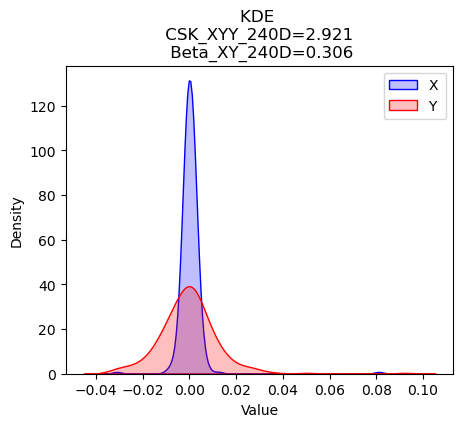

In [10]:
# 假设 test_beta1 和 test3 是已经定义的 DataFrame
test_beta = all_stk3.iloc[8401868-241:8401868,:]
test = all_stk2.iloc[8401868-241:8401868,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


In [16]:
all_stk2[(all_stk2['CSK_XYY_240D']>=2.5)&(all_stk2['CSK_XYY_240D']<=3)]

,WINDCODE,tradedate,pct_chg,S_DQ_PCTCHANGE,CSK_XYY_20D,CSK_XYY_60D,CSK_XYY_120D,CSK_XYY_240D,CSK_XYY_UP_20D,CSK_XYY_UP_60D,CSK_XYY_UP_120D,CSK_XYY_UP_240D,CSK_XYY_DOWN_20D,CSK_XYY_DOWN_60D,CSK_XYY_DOWN_120D,CSK_XYY_DOWN_240D
552318,000425.SZ,2003-03-18,-0.000530,-0.007397,-0.287895,0.333376,-0.016522,2.523977,1.118892,1.297646,0.868728,3.489140,-1.239063,-1.428219,-1.314946,-0.750949
552319,000425.SZ,2003-03-19,0.001590,0.003255,-0.215429,0.360668,-0.016667,2.559528,1.071507,1.288655,0.868739,3.494384,-1.276340,-1.432401,-1.315186,-0.775255
552320,000425.SZ,2003-03-20,-0.000529,-0.003900,-0.180449,0.372771,-0.012745,2.557835,1.486034,1.300186,0.868972,3.496982,-1.281048,-1.437697,-1.324439,-0.778584
552321,000425.SZ,2003-03-21,0.001588,0.009347,-0.081904,0.413564,0.006844,2.605140,1.503245,1.346403,0.880304,3.552595,-1.353615,-1.410329,-1.408985,-0.781159
552322,000425.SZ,2003-03-24,0.001586,0.001652,0.085014,0.400547,0.020627,2.609955,1.386560,1.333883,0.919264,3.557309,-1.350139,-1.414157,-1.405464,-0.779407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11482084,600737.SH,2003-06-25,-0.002620,-0.007798,0.246321,0.314521,0.380560,2.511136,0.937141,1.313212,1.181013,3.439265,-0.942653,-0.887771,-0.494388,-0.634886
11482085,600737.SH,2003-06-27,0.001037,-0.014016,0.243556,0.357562,0.397084,2.546938,0.933628,1.306766,1.205426,3.464923,-0.956184,-0.874697,-0.480132,-0.631472
11482086,600737.SH,2003-06-30,-0.003591,-0.007433,0.464569,0.377338,0.407486,2.544061,1.033441,1.273932,1.181584,3.462574,-0.567899,-0.833875,-0.472832,-0.629058
11482087,600737.SH,2003-07-01,0.002079,-0.002652,0.635208,0.381348,0.421360,2.557403,1.145585,1.280371,1.180545,3.482829,-0.439559,-0.810489,-0.464722,-0.630290


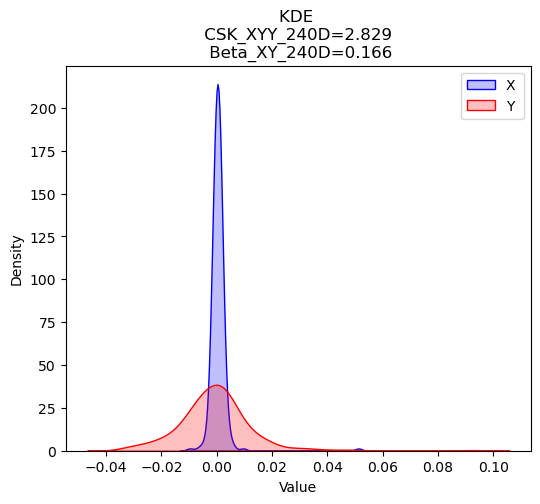

In [19]:
# 假设 test_beta1 和 test3 是已经定义的 DataFrame
test_beta = all_stk3.iloc[1265978-241:1265978,:]
test = all_stk2.iloc[1265978-241:1265978,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(6, 5))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


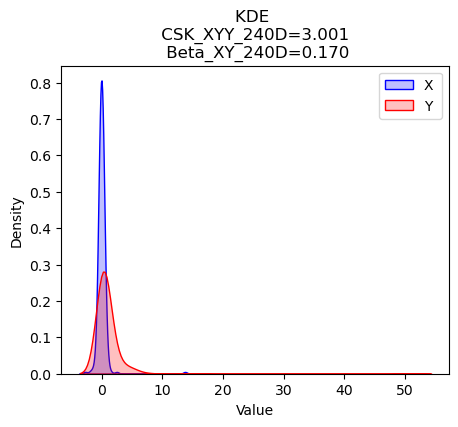

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[1266037-241:1266037,:]
test = all_stk2.iloc[1266037-241:1266037,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std())**2, color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

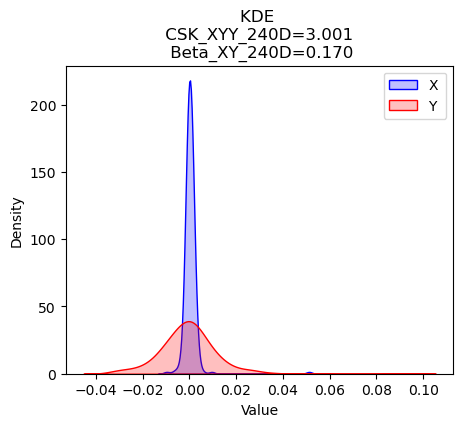

In [15]:
# 假设 test_beta1 和 test3 是已经定义的 DataFrame
test_beta = all_stk3.iloc[1266037-241:1266037,:]
test = all_stk2.iloc[1266037-241:1266037,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


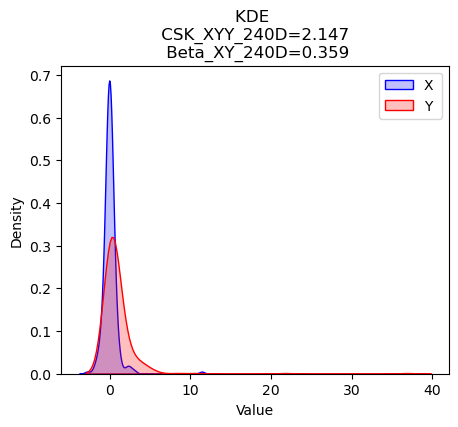

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[552297-241:552297,:]
test = all_stk2.iloc[552297-241:552297,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std())**2, color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

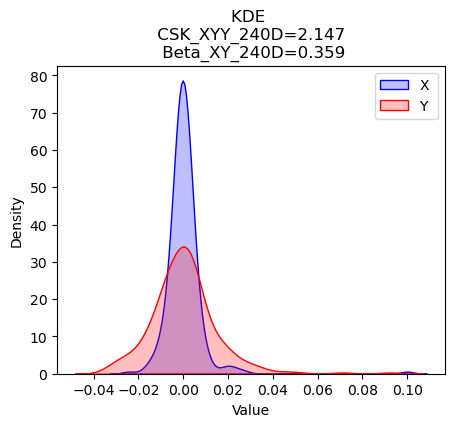

In [ ]:
# 假设 test_beta1 和 test3 是已经定义的 DataFrame
test_beta = all_stk3.iloc[552297-241:552297,:]
test = all_stk2.iloc[552297-241:552297,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


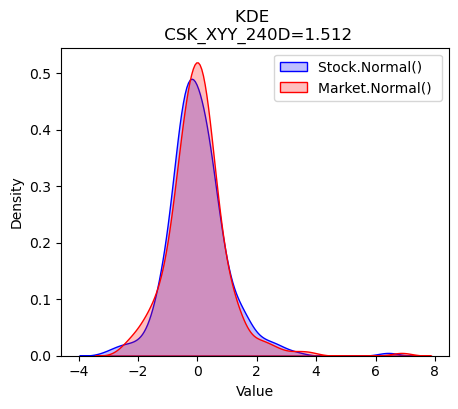

In [311]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[7493-241:7493,:]
test = all_stk2.iloc[7493-241:7493,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='Stock.Normal() ', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std()), color='red', label='Market.Normal() ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

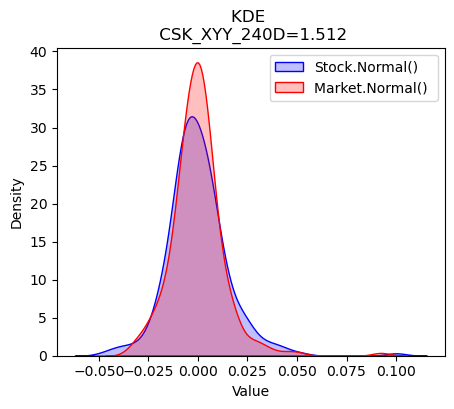

In [310]:
# 假设 test_beta1 和 test3 是已经定义的 DataFrame
test_beta = all_stk3.iloc[7493-241:7493,:]
test = all_stk2.iloc[7493-241:7493,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='Stock.Normal()', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Market.Normal() ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


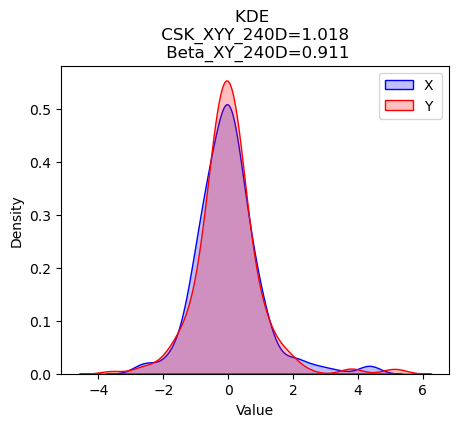

In [307]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[1133-241:1133,:]
test = all_stk2.iloc[1133-241:1133,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std())**2, color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

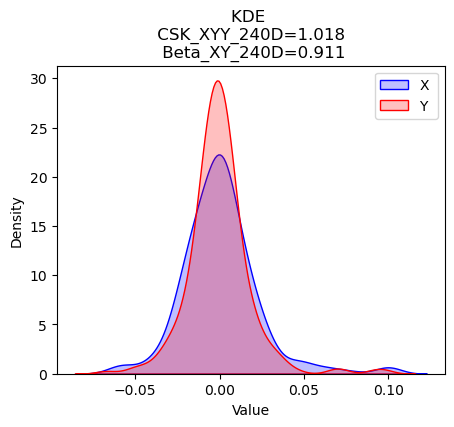

In [ ]:
# 假设 test_beta1 和 test3 是已经定义的 DataFrame
test_beta = all_stk3.iloc[1133-241:1133,:]
test = all_stk2.iloc[1133-241:1133,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


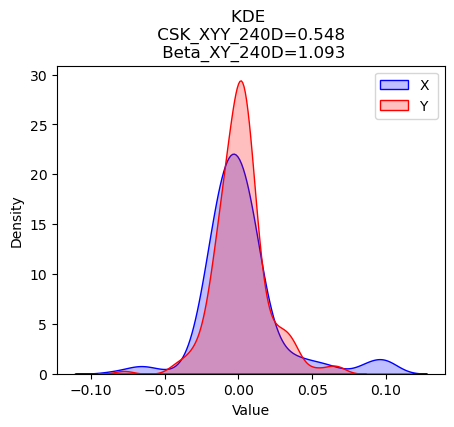

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[412-241:412,:]
test = all_stk2.iloc[412-241:412,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


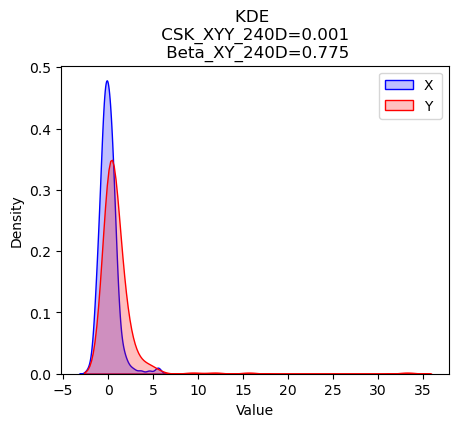

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[332-241:332,:]
test = all_stk2.iloc[332-241:332,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std())**2, color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

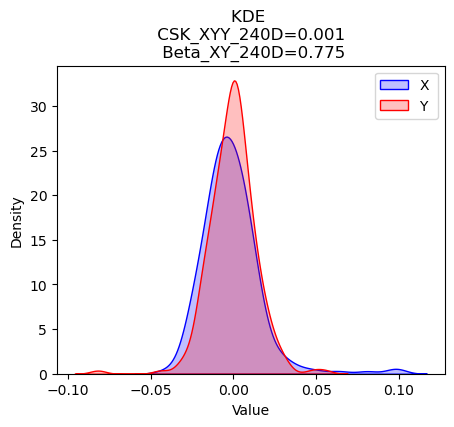

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[332-241:332,:]
test = all_stk2.iloc[332-241:332,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


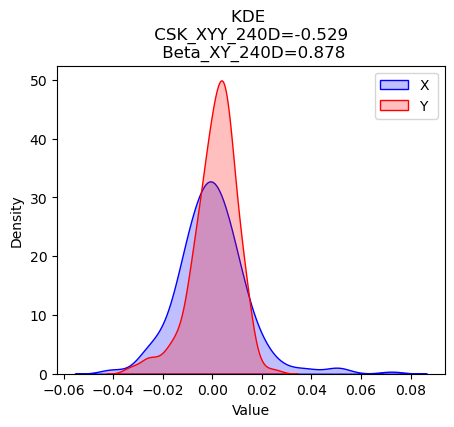

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[802-241:802,:]
test = all_stk2.iloc[802-241:802,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


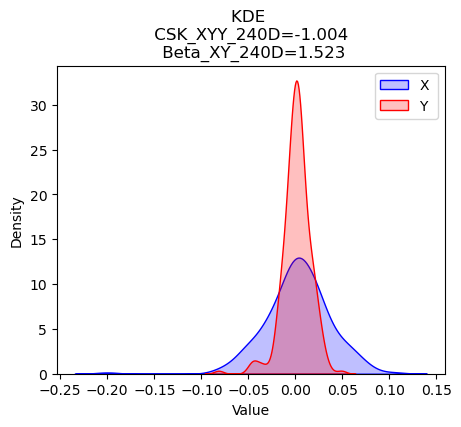

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[14358878-241:14358878,:]
test = all_stk2.iloc[14358878-241:14358878,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


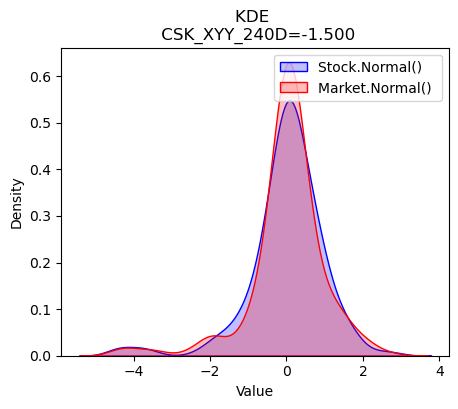

In [313]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[137556-241:137556,:]
test = all_stk2.iloc[137556-241:137556,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='Stock.Normal() ', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std()), color='red', label='Market.Normal() ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

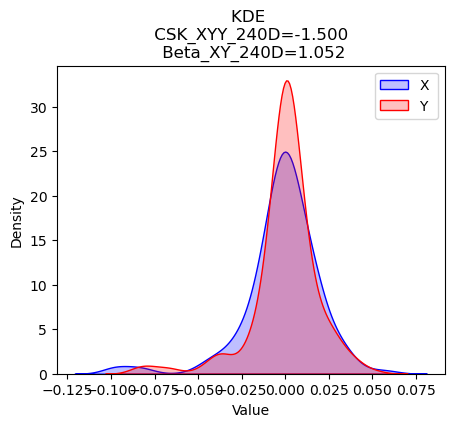

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[137556-241:137556,:]
test = all_stk2.iloc[137556-241:137556,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()


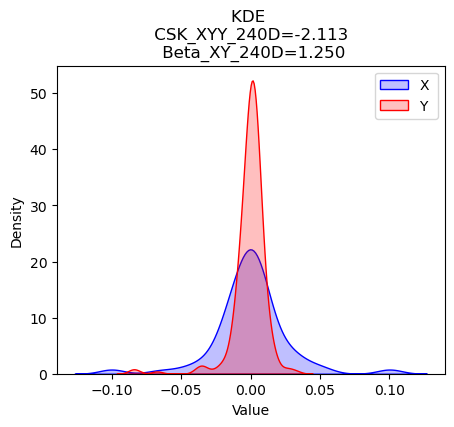

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[971986-241:971986,:]
test = all_stk2.iloc[971986-241:971986,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

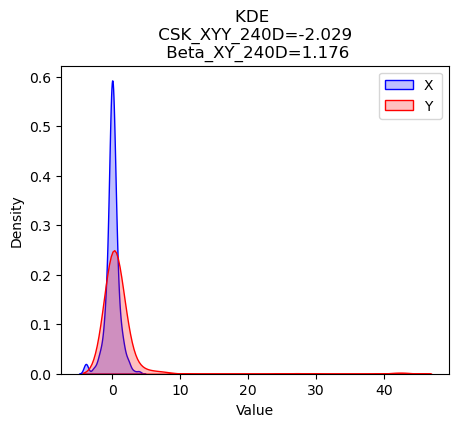

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[2320907-241:2320907,:]
test = all_stk2.iloc[2320907-241:2320907,:]
# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot((test['pct_chg']-test['pct_chg'].mean())/test['pct_chg'].std(), color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(((test['S_DQ_PCTCHANGE']-test['S_DQ_PCTCHANGE'].mean())/test['S_DQ_PCTCHANGE'].std())**2, color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

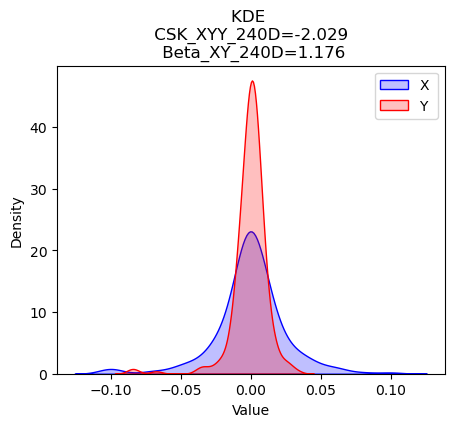

In [ ]:
# 假设 test_beta 和 test 是已经定义的 DataFrame
test_beta = all_stk3.iloc[2320907-241:2320907,:]
test = all_stk2.iloc[2320907-241:2320907,:]

# 创建一个图表
fig, ax = plt.subplots(figsize=(5, 4))

# 在同一个子图中绘制 test_beta 和 test 的数据
sns.kdeplot(test['pct_chg'], color='blue', label='X', fill=True, ax=ax)
sns.kdeplot(test['S_DQ_PCTCHANGE'], color='red', label='Y ', fill=True, ax=ax)

# 添加标题和标签
ax.set_title(f'KDE \n CSK_XYY_240D={test['CSK_XYY_240D'].iloc[-1]:.3f} \n Beta_XY_240D={test_beta['Beta_XY_240D'].iloc[-1]:.3f}')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 显示图形
plt.show()

# 4.使用 PCA 降维合成获得 CSK_XYY_UP_DOWN因子

PCA 降维是一种机械学习算法，简单理解就是一种降低数据维度的方法，例如此处我们将对应日期的 CSK_XYY_UP与 CSK_XYY_DOWN因子，在每个横截面可以得到所有股票的一组 N*2 向量，在向量标准化后，通过 PCA 即可以将该向量转化为一组 N*1 向量，我们把这组 N*1 向量返回为 CSK_XYY_UP_DOWN 因子

In [ ]:
path ='/Users/hmt/Documents/PHBS/courses/investment/project/data'
all_stk2 = pd.read_parquet(f'{path}/因子数据.parquet',engine='pyarrow')
all_stk2['tradedate'] = pd.to_datetime(all_stk2['tradedate'])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# 定义一个函数来进行PCA降维
def pca_reduction(group,X):
    # 选择需要标准化的列
    features = [f'CSK_XYY_UP_{X}D', f'CSK_XYY_DOWN_{X}D']
    # 标准化数据
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(group[features])
    # 进行PCA降维
    pca = PCA(n_components=1)
    reduced = pca.fit_transform(scaled_features)
    # 将降维结果添加到DataFrame中
    group[f'CSK_XYY_UP_DOWN_{X}D'] = reduced
    return group

In [ ]:
#降维获得因子
for X in [20,60,120,240]:
    # 按时间横截面进行分组，并对每个组应用PCA降维
    all_stk3 = all_stk2[all_stk2[f'CSK_XYY_{X}D'].notna()]
    test = all_stk3.groupby('tradedate').apply(lambda x:pca_reduction(x,X)).reset_index(drop=True)
    test.sort_values(by=['WINDCODE','tradedate'],inplace=True)
    test.reset_index(inplace=True,drop=True)
    all_stk2 = pd.merge(all_stk2,test[['WINDCODE','tradedate',f'CSK_XYY_UP_DOWN_{X}D']],on=['WINDCODE','tradedate'],how='left')

In [ ]:
all_stk2.tail(20)

# 保存已经完成计算的因子，合并原日行情数据，并合并估值数据（市值）

In [ ]:
all_stk2.to_parquet(f'{path}/coskew因子',engine='pyarrow')

In [ ]:
price = pd.read_parquet(f'{path}/windA股日行情.parquet', engine='pyarrow')
price['tradedate'] = pd.to_datetime(price['tradedate'],format='%Y%m%d')
#剔除北交所股票
price =  price[~price['WINDCODE'].str.endswith('.BJ')]
#把量价数据进行排序
price.sort_values(by=['WINDCODE','tradedate'],inplace=True)
price.reset_index(inplace=True,drop=True)
#转化一下 pct_chg 的单位
price['pct_chg'] = price['复权close']/price['复权preclose']-1   

In [ ]:
price_Ashare = pd.merge(price, all_stk2, on=['WINDCODE','tradedate'], how='left')
price_Ashare.drop(columns=['pct_chg_x','pct_chg_y','S_DQ_PCTCHANGE'],inplace=True)
#再存一下因子+日行情数据
price_Ashare.to_parquet(f'{path}/日行情及因子数据.parquet',engine='pyarrow')

In [ ]:
mkt = pd.read_parquet(f'{path}/A股估值指标日行情.parquet',engine='pyarrow')
mkt['tradedate'] = pd.to_datetime(mkt['tradedate'],format='%Y%m%d')

In [ ]:
stockprice  = pd.merge(price_Ashare, mkt, on=['WINDCODE','tradedate'], how='left')
# 最后存一下日行情+估值+因子数据
stockprice.to_parquet(f'{path}/日行情估值及因子数据.parquet',engine='pyarrow')